In [2]:
import requests
from bs4 import BeautifulSoup

In [3]:
base_url = "https://dados.ons.org.br"

In [4]:
response = requests.get(base_url)
soup = BeautifulSoup(response.content, "html.parser")

# Seleciona a UL específica
ul = soup.select_one(
    "body > div.homepage.layout-1 > div:nth-child(4) > div > div > div > div > div > ul:nth-child(6)"
)

# Extrai os links e títulos
links = []
titles = []

for a in ul.find_all('a', href=True):
    links.append(a['href'])
    titles.append(a.get_text(strip=True))

print("Links:", links)
print("Títulos:", titles)

Links: ['https://dados.ons.org.br/dataset/balanco_dessem_geral', 'https://dados.ons.org.br/dataset/balanco_dessem_detalhe', 'https://dados.ons.org.br/dataset/balanco-energia-subsistema', 'https://dados.ons.org.br/dataset/capacidade-geracao', 'https://dados.ons.org.br/dataset/capacidade-transformacao', 'https://dados.ons.org.br/dataset/carga-energia', 'https://dados.ons.org.br/dataset/carga-mensal', 'https://dados.ons.org.br/dataset/carga-energia-programada', 'https://dados.ons.org.br/dataset/carga-energia-verificada', 'https://dados.ons.org.br/dataset/cargaglobal-roraima', 'https://dados.ons.org.br/dataset/cmo-semanal', 'https://dados.ons.org.br/dataset/cmo-semi-horario', 'https://dados.ons.org.br/dataset/curva-carga', 'https://dados.ons.org.br/dataset/cvu-usitermica', 'https://dados.ons.org.br/dataset/bacia_contorno', 'https://dados.ons.org.br/dataset/dados-hidrologicos-res', 'https://dados.ons.org.br/dataset/dados_hidrologicos_ho', 'https://dados.ons.org.br/dataset/res_volumeespera',

In [5]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime

def get_ons_dataset_list():
    base_url = "https://dados.ons.org.br"
    response = requests.get(base_url)
    soup = BeautifulSoup(response.content, "html.parser")

    # Seleciona a UL específica
    ul = soup.select_one(
        "body > div.homepage.layout-1 > div:nth-child(4) > div > div > div > div > div > ul:nth-child(6)"
    )

    links = []
    titles = []

    if ul:
        for a in ul.find_all('a', href=True):
            links.append(a['href'])
            titles.append(a.get_text(strip=True))

    return list(zip(titles, links))

def get_ons_dataset(item_name, date_str, extenstion=".parquet"):
    """
    item_name : nome ou parte do nome do dataset (ex: "balanco_dessem_geral")
    date_str  : data no formato "YYYY_MM_DD" (ex: "2025_09_23")
    """
    base_url = f"https://dados.ons.org.br/dataset/{item_name}"
    response = requests.get(base_url)
    if response.status_code != 200:
        raise Exception(f"Erro ao acessar {base_url}")

    soup = BeautifulSoup(response.content, "html.parser")

    resource_links = soup.select("a.resource-url-analytics[href]")

    for a in resource_links:
        href = a['href']
        if date_str in href and href.endswith(extenstion):
            return href  # Retorna o link de download direto

    return None

# Exemplo de uso
item = "ear-diario-por-bacia"
date = "2023"
download_link = get_ons_dataset(item, date)

if download_link:
    print("Link encontrado:", download_link)
else:
    print("Arquivo não encontrado para essa data.")

Link encontrado: https://ons-aws-prod-opendata.s3.amazonaws.com/dataset/ear_bacia_di/EAR_DIARIO_BACIAS_2023.parquet


In [6]:
import requests
response = requests.get(download_link)

with open("file.parquet", "wb") as f:
    f.write(response.content)

In [7]:
import pandas as pd 

data = pd.read_parquet("file.parquet")

In [8]:
data.columns

Index(['nomecurto', 'ear_data', 'ear_max_bacia', 'ear_verif_bacia_mwmes',
       'ear_verif_bacia_percentual'],
      dtype='object')

In [9]:
[len(data[col].unique()) for col in data.columns]

[18, 365, 18, 5732, 5706]

In [10]:
import pandas as pd

def extract_statistics(df: pd.DataFrame):
    stats = {}

    for col in df.columns:
        series = df[col].dropna()

        if pd.api.types.is_datetime64_any_dtype(series):
            stats[col] = {
                "tipo": "data",
                "inicio": series.min(),
                "fim": series.max()
            }

        elif series.dtype == "object" or series.nunique() < 50:
            freq = series.value_counts().to_dict()
            stats[col] = {
                "tipo": "categorica",
                "frequencias": freq
            }

        elif pd.api.types.is_numeric_dtype(series):
            desc = series.describe(percentiles=[0.25, 0.5, 0.75]).to_dict()
            stats[col] = {
                "tipo": "continua",
                "min": desc["min"],
                "q1": desc["25%"],
                "mediana": desc["50%"],
                "q3": desc["75%"],
                "max": desc["max"],
                "media": desc["mean"],
                "desvio_padrao": series.std(),
                "variancia": series.var(),
                "amplitude": desc["max"] - desc["min"],
                "n": int(desc["count"])
            }

        else:
            stats[col] = {"tipo": "desconhecido"}

    return stats

In [11]:
def format_statistics_text(estatisticas: dict) -> str:
    texto = []
    
    for col, info in estatisticas.items():
        if info["tipo"] == "categorica":
            texto.append(f"A variável **{col}** é categórica. "
                         f"Ela possui as seguintes frequências: "
                         + ", ".join([f"{k}: {v}" for k, v in info["frequencias"].items()]))
        
        elif info["tipo"] == "data":
            texto.append(f"A variável **{col}** é temporal. "
                         f"Seu período vai de {info['inicio']} até {info['fim']}.")
        
        elif info["tipo"] == "continua":
            texto.append(
                f"A variável **{col}** é contínua. "
                f"Possui {info['n']} observações. "
                f"Seu valor mínimo é {info['min']}, o primeiro quartil (Q1) é {info['q1']}, "
                f"a mediana é {info['mediana']}, o terceiro quartil (Q3) é {info['q3']} e o valor máximo é {info['max']}. "
                f"A média é {info['media']}, com desvio padrão de {info['desvio_padrao']} "
                f"e variância de {info['variancia']}. A amplitude é {info['amplitude']}."
            )
        
        else:
            texto.append(f"A variável **{col}** possui tipo desconhecido e não foi sumarizada.")
    
    return "\n\n".join(texto)

In [12]:
data["ear_data"] = pd.to_datetime(data["ear_data"], errors="coerce")
estatisticas = extract_statistics(data)

import json
print(json.dumps(estatisticas, indent=2, default=str))

{
  "nomecurto": {
    "tipo": "categorica",
    "frequencias": {
      "AMAZONAS": 365,
      "CAPIVARI": 365,
      "TOCANTINS": 365,
      "TIETE": 365,
      "SAO FRANCISCO": 365,
      "PARNAIBA": 365,
      "PARANAPANEMA": 365,
      "PARANAIBA": 365,
      "PARANA": 365,
      "PARAIBA DO SUL": 365,
      "PARAGUAI": 365,
      "PARAGUACU": 365,
      "JEQUITINHONHA": 365,
      "JACUI": 365,
      "IGUACU": 365,
      "GRANDE": 365,
      "DOCE": 365,
      "URUGUAI": 365
    }
  },
  "ear_data": {
    "tipo": "data",
    "inicio": "2023-01-01 00:00:00",
    "fim": "2023-12-31 00:00:00"
  },
  "ear_max_bacia": {
    "tipo": "categorica",
    "frequencias": {
      "2028.23095703125": 365,
      "374.95599365234375": 365,
      "49880.60546875": 365,
      "9725.24609375": 365,
      "52727.2109375": 365,
      "264.1780090332031": 365,
      "12094.4912109375": 365,
      "78500.9453125": 365,
      "3691.574951171875": 365,
      "7554.89697265625": 365,
      "555.79797363281

In [13]:
descricao = format_statistics_text(estatisticas)
print(descricao)

A variável **nomecurto** é categórica. Ela possui as seguintes frequências: AMAZONAS: 365, CAPIVARI: 365, TOCANTINS: 365, TIETE: 365, SAO FRANCISCO: 365, PARNAIBA: 365, PARANAPANEMA: 365, PARANAIBA: 365, PARANA: 365, PARAIBA DO SUL: 365, PARAGUAI: 365, PARAGUACU: 365, JEQUITINHONHA: 365, JACUI: 365, IGUACU: 365, GRANDE: 365, DOCE: 365, URUGUAI: 365

A variável **ear_data** é temporal. Seu período vai de 2023-01-01 00:00:00 até 2023-12-31 00:00:00.

A variável **ear_max_bacia** é categórica. Ela possui as seguintes frequências: 2028.23095703125: 365, 374.95599365234375: 365, 49880.60546875: 365, 9725.24609375: 365, 52727.2109375: 365, 264.1780090332031: 365, 12094.4912109375: 365, 78500.9453125: 365, 3691.574951171875: 365, 7554.89697265625: 365, 555.7979736328125: 365, 335.38299560546875: 365, 2967.7880859375: 365, 3029.35400390625: 365, 10062.9345703125: 365, 51531.44140625: 365, 12.89900016784668: 365, 6730.26123046875: 365

A variável **ear_verif_bacia_mwmes** é contínua. Possui 657

In [14]:
PROMPT_BASE = """Você é um especialista do setor elétrico brasileiro escrevendo um capítulo de livro 
voltado a leitores leigos, mas interessados em entender como funciona o sistema. 

Receberá abaixo estatísticas descritivas de uma série temporal do ONS 
(Operador Nacional do Sistema Elétrico). 

--- Estatísticas da série temporal ---
{{ESTATISTICAS_TEXT}}
--- Fim das estatísticas ---

Sua tarefa é transformar esses números em uma narrativa clara, acessível e didática.  
Escreva como se fosse uma explicação em livro, contando a história que os dados revelam.  

Siga estas orientações:

1. **Explicação das métricas**  
   - Apresente o que significa cada variável, em especial métricas como EAR (Energia Armazenada Equivalente).  
   - Explique em linguagem simples, com analogias se necessário (ex.: “é como o nível da caixa d’água do país”).  

2. **Cobertura temporal**  
   - Diga o período coberto pela série e o que isso representa no ciclo hidrológico.  
   - Avalie se há consistência ou lacunas.  

3. **História do ano observado**  
   - Narre os padrões que aparecem nos dados (médias, extremos, sazonalidade).  
   - Mostre como as variações se relacionam a chuvas, secas ou outros fatores do setor elétrico.  
   - Quando for uma interpretação inferida, marque como “[Suposição]: ...”.  

4. **Importância para o setor**  
   - Explique como esse tipo de dado é usado pelo ONS no planejamento e operação.  
   - Dê exemplos práticos (acionar termelétricas, gerenciar riscos de seca, planejar transmissão).  

5. **Limitações e próximos passos**  
   - Aponte limitações observadas nos dados (ex.: granularidade, outliers, variáveis faltantes).  
   - Sugira comparações futuras (com outros anos, outras bacias, previsões).  

Formato de saída:  
- Texto corrido, como se fosse um capítulo de livro.  
- Linguagem clara, formal, mas acessível para quem não é especialista.  
- Evite listas técnicas; priorize a narrativa fluida. """

In [15]:
descricao = format_statistics_text(estatisticas)

prompt_text = PROMPT_BASE.replace("{{ESTATISTICAS_TEXT}}", descricao)

from mlx_lm import load, generate

model, tokenizer = load("mlx-community/Mistral-7B-Instruct-v0.3-4bit")

messages = [{"role": "user", "content": prompt_text}]
prompt = tokenizer.apply_chat_template(messages, add_generation_prompt=True)

text = generate(
    model,
    tokenizer,
    prompt=prompt,
    max_tokens=1500,   
    verbose=True
)
print(text)

/opt/miniconda3/envs/game_ai/lib/python3.12/site-packages/sklearn/utils/_param_validation.py:11: UserWarning: A NumPy version >=1.23.5 and <2.3.0 is required for this version of SciPy (detected version 2.3.3)
  from scipy.sparse import csr_matrix, issparse


Fetching 7 files:   0%|          | 0/7 [00:00<?, ?it/s]

Capítulo 1: O Sistema Elétrico Brasileiro: Uma História em Números

O sistema elétrico brasileiro é um mundo complexo, onde energia é produzida, transportada e distribuída para atender às necessidades de milhões de pessoas. Para entender melhor como isso funciona, vamos explorar um conjunto de dados que descreve o comportamento do sistema durante um ano.

Primeiro, vamos conhecer as variáveis que compõem nossa análise.

- **nomecurto**: Este campo representa as bacias hidrográficas do sistema elétrico brasileiro. Cada uma dessas bacias tem um papel crucial na produção de energia elétrica, como a bacia do rio Amazonas, que é a maior do país.

- **ear_data**: Este campo indica a data de cada observação, abrangendo todo o ano de 2023.

- **ear_max_bacia**: Este campo indica a capacidade de armazenamento máxima de cada bacia hidrográfica, medida em megawatts-meses (MWmes). Essa capacidade é como a quantidade de água que uma bacia pode armazenar para uso futuro.

- **ear_verif_bacia_mwmes**

In [28]:
import pandas as pd

arquivo = "/Users/eduardo/Downloads/DataRecords.csv"

df = pd.read_csv(
    arquivo,
    # encoding="latin1",   # ou ISO-8859-1
    sep=";",             # separador padrão do INMET
    # skiprows=8           # pula as linhas de metadados
)

print(df.head())
print(df.columns)

   OBJECTID Id da Instalação  \
0         1           PBUCG    
1         2           RSUSSE   
2         3           MAUTP5   
3         4           SPUFD1   
4         5           SPUFD2   

                              Modalidade de Operação  \
0     USINA CUJA OPERAÇÃO IMPACTA A REDE DE OPERAÇÃO   
1  UTE COM CVU DECLARADO, QUE NÃO IMPACTA A REDE ...   
2     USINA CUJA OPERAÇÃO IMPACTA A REDE DE OPERAÇÃO   
3             USINA PERTENCENTE A CONJUNTO DE USINAS   
4             USINA PERTENCENTE A CONJUNTO DE USINAS   

                                                Nome Data Prevista  \
0  USI CAMPINA GRANDE                            ...    30/01/2011   
1  USI UTE SAO SEPE                              ...    14/11/2018   
2  USI UTE PARNAIBA V                            ...    27/08/2021   
3  USI USINA FOTOVOLTAICA DRACENA 1              ...    30/05/2019   
4  USI USINA FOTOVOLTAICA DRACENA 2              ...    30/05/2019   

  Data Prevista.1 Data Entrada Data Entrada.1 Tip

In [29]:
df[['Tipo', 'x', 'y']] = df['Tipo de Usina,x,y'].str.split(",", expand=True)

In [30]:
import plotly.express as px

# Converte x e y para numéricos (caso estejam como string)
df["x"] = pd.to_numeric(df["x"], errors="coerce")
df["y"] = pd.to_numeric(df["y"], errors="coerce")

# Remove linhas sem coordenadas válidas
df_map = df.dropna(subset=["x", "y"])

# Cria o mapa
fig = px.scatter_mapbox(
    df_map,
    lat="y", 
    lon="x", 
    hover_name="Nome", 
    hover_data={"Tipo": True, "x": True, "y": True},
    color="Tipo", 
    zoom=3,
    height=600
)

# Define o estilo do mapa (requer token do Mapbox ou usa open-street-map)
fig.update_layout(mapbox_style="open-street-map")

# Mostra o mapa
fig.show()

In [73]:
from docling.document_converter import DocumentConverter

source = "https://arxiv.org/pdf/2408.09869"  # file path or URL
converter = DocumentConverter()
doc = converter.convert("DicionarioDados_DadosHidrologicosDiarios.pdf").document

print(doc.export_to_markdown())  # output: "### Docling Technical Report[...]"

<!-- image -->

Data: 22-08-2024 - Página 1

## DADOS HIDROLÓGICOS DE RESERVATÓRIOS - BASE DIÁRIA

Descrição do Dado: Dados hidrológicos de reservatórios consolidados pelo ONS em periodicidade diária.

| Descrição                                                   | Código           | Tipo de Dado   | Formato             | Permite valor nulo   | Permite valor zerado   | Permite valor negativo   |
|-------------------------------------------------------------|------------------|----------------|---------------------|----------------------|------------------------|--------------------------|
| Identificador do subsistema                                 | id_subsistema    | TEXTO          | 2 POSIÇÕES          | Não                  | ----                   | ----                     |
| Nome do subsistema                                          | nom_subsistema   | TEXTO          | 40 POSIÇÕES         | Não                  | ----                   | ----                     |
| Tipo do 

In [76]:
import re

pattern = r"\|([^|]+)\|([^|]+)\|([^|]+)\|([^|]+)\|([^|]+)\|([^|]+)\|([^|]+)\|"

# Encontrar todas as correspondências
matches = re.findall(pattern, doc.export_to_markdown())

# Extrair cabeçalho e dados
header = [col.strip() for col in matches[0]]
data = [tuple(col.strip() for col in row) for row in matches[1:]]

# Criar o DataFrame
df = pd.DataFrame(data, columns=header)

# Exibir o DataFrame
print(df)

                                            Descrição  \
0   ----------------------------------------------...   
1                         Identificador do subsistema   
2                                  Nome do subsistema   
3                                Tipo do reservatório   
4   Nome da bacia em que o reservatório está local...   
5   Nome do reservatório equivalente de energia do...   
6                       Identificador do reservatório   
7                                Nome do reservatório   
8                    Ordem do reservatório na cascata   
9           Código da usina nos modelos de otimização   
10                                               Data   
11                                          Descrição   
12            ---------------------------------------   
13                 Valor do nível montante, em metros   
14                  Valor do nível jusante, em metros   
15                Valor do volume útil consistido (%)   
16                             

In [77]:
df

,Descrição,Código,Tipo de Dado,Formato,Permite valor nulo,Permite valor zerado,Permite valor negativo
0,----------------------------------------------...,------------------,----------------,---------------------,----------------------,------------------------,--------------------------
1,Identificador do subsistema,id_subsistema,TEXTO,2 POSIÇÕES,Não,----,----
2,Nome do subsistema,nom_subsistema,TEXTO,40 POSIÇÕES,Não,----,----
3,Tipo do reservatório,tip_reservatorio,TEXTO,40 POSIÇÕES,Não,----,----
4,Nome da bacia em que o reservatório está local...,nom_bacia,TEXTO,15 POSIÇÕES,Não,----,----
5,Nome do reservatório equivalente de energia do...,nom_ree,TEXTO,20 POSIÇÕES,Sim,----,----
6,Identificador do reservatório,id_reservatorio,TEXTO,6 POSIÇÕES,Não,----,----
7,Nome do reservatório,nom_reservatorio,TEXTO,20 POSIÇÕES,Não,----,----
8,Ordem do reservatório na cascata,num_ordemcs,INTEIRO,,Sim,Não,Não
9,Código da usina nos modelos de otimização,cod_usina,INTEIRO,,Sim,Não,Não


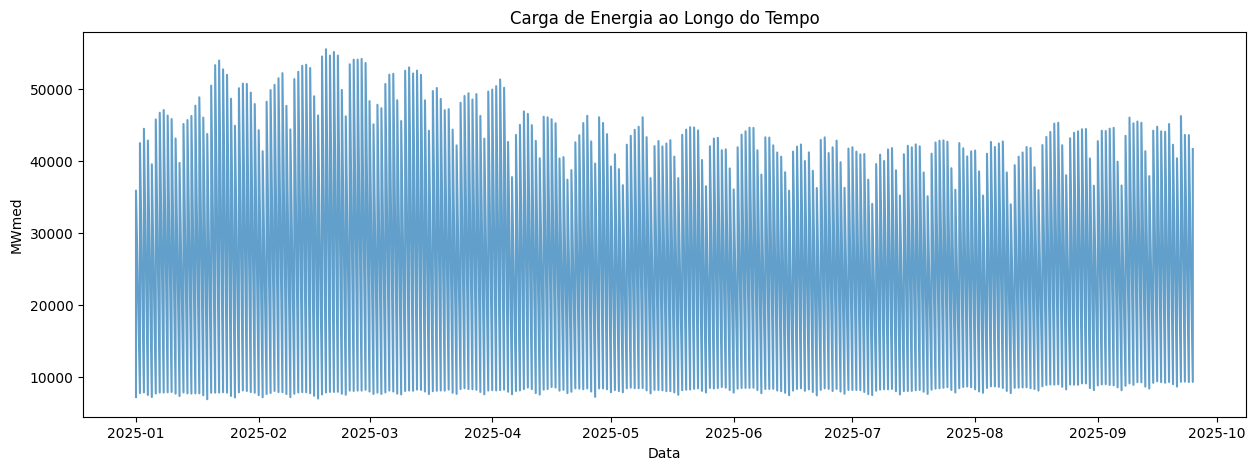

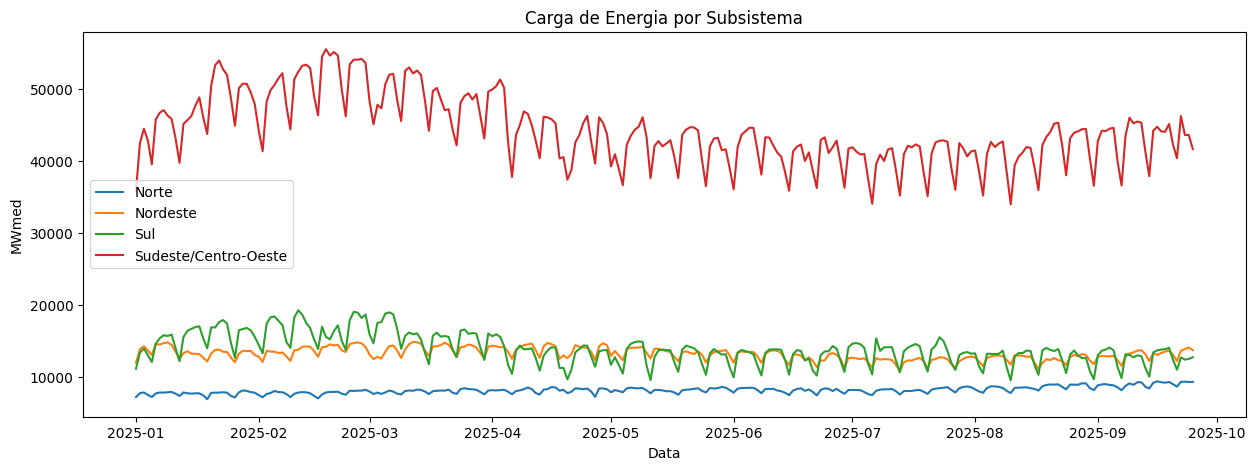

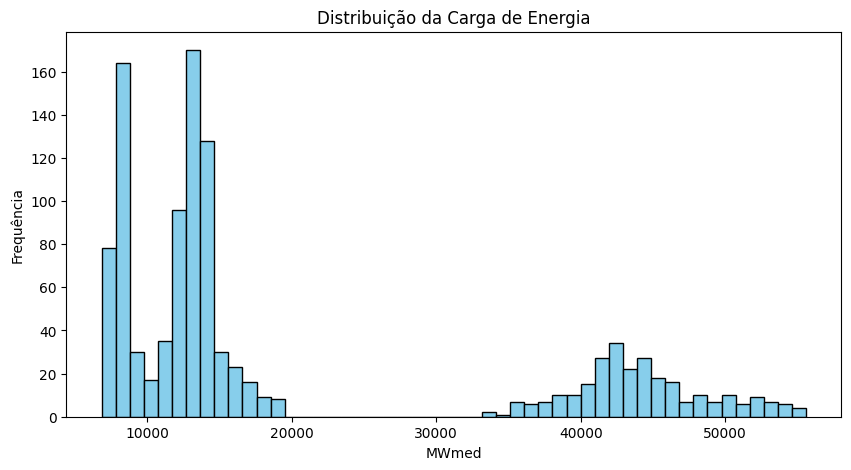

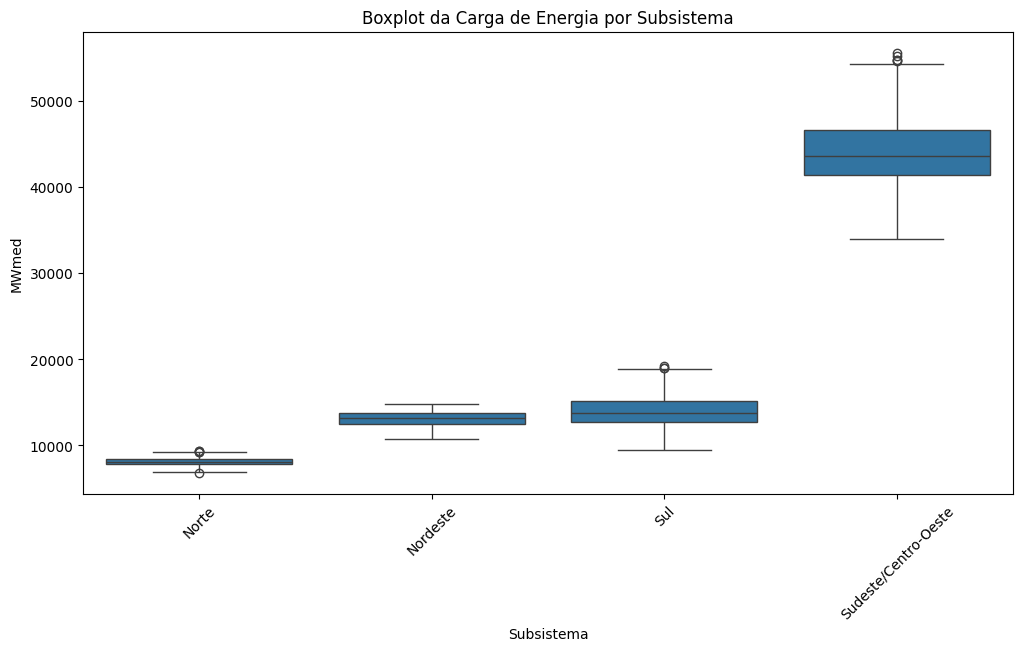

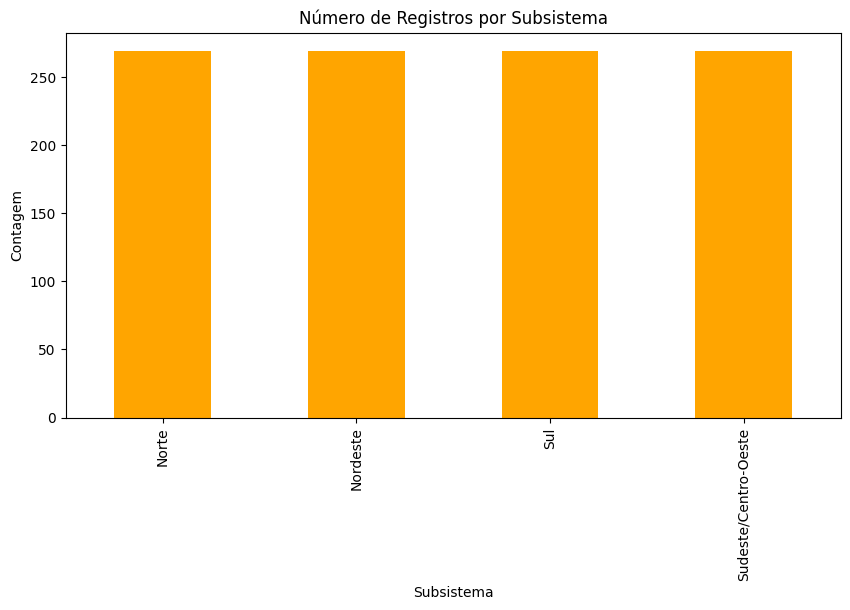

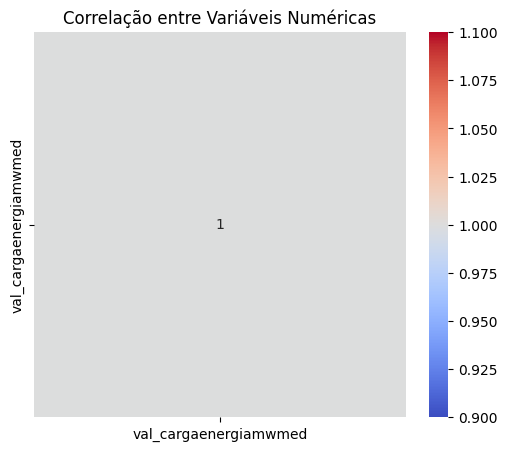

In [31]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

data_path = "DatathONS-11/CARGA_ENERGIA_2025.parquet"
dict_path = "DatathONS-11/Dicts/DicionarioDados_Carga_Energia_Diaria.csv"

df = pd.read_parquet(data_path)
df['din_instante'] = pd.to_datetime(df['din_instante'])

dict_df = pd.read_csv(dict_path, encoding='utf-8')


plt.figure(figsize=(15,5))
plt.plot(df['din_instante'], df['val_cargaenergiamwmed'], alpha=0.7)
plt.title("Carga de Energia ao Longo do Tempo")
plt.xlabel("Data")
plt.ylabel("MWmed")
plt.show()

plt.figure(figsize=(15,5))
for subs in df['nom_subsistema'].unique():
    df_sub = df[df['nom_subsistema'] == subs]
    plt.plot(df_sub['din_instante'], df_sub['val_cargaenergiamwmed'], label=subs)
plt.legend()
plt.title("Carga de Energia por Subsistema")
plt.xlabel("Data")
plt.ylabel("MWmed")
plt.show()

plt.figure(figsize=(10,5))
plt.hist(df['val_cargaenergiamwmed'], bins=50, color='skyblue', edgecolor='black')
plt.title("Distribuição da Carga de Energia")
plt.xlabel("MWmed")
plt.ylabel("Frequência")
plt.show()

plt.figure(figsize=(12,6))
sns.boxplot(data=df, x='nom_subsistema', y='val_cargaenergiamwmed')
plt.title("Boxplot da Carga de Energia por Subsistema")
plt.xlabel("Subsistema")
plt.ylabel("MWmed")
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(10,5))
df['nom_subsistema'].value_counts().plot(kind='bar', color='orange')
plt.title("Número de Registros por Subsistema")
plt.xlabel("Subsistema")
plt.ylabel("Contagem")
plt.show()

plt.figure(figsize=(6,5))
sns.heatmap(df[['val_cargaenergiamwmed']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlação entre Variáveis Numéricas")
plt.show()

In [1]:
import pandas as pd
import plotly.express as px
from statsmodels.tsa.seasonal import seasonal_decompose

# Paths
data_path = "DatathONS-11/CARGA_ENERGIA_2025.parquet"
dict_path = "DatathONS-11/Dicts/DicionarioDados_Carga_Energia_Diaria.csv"

# Carregar dados
df = pd.read_parquet(data_path)

# Carregar dicionário
dict_df = pd.read_csv(dict_path, encoding='utf-8')

# Mapear tipos
tipo_map = dict(zip(dict_df['Código'], dict_df['Tipo de Dado']))

# Identificar colunas por tipo
num_cols = [col for col, tipo in tipo_map.items() if tipo in ['FLOAT', 'INT']]
cat_cols = [col for col, tipo in tipo_map.items() if tipo == 'TEXTO']
date_cols = [col for col, tipo in tipo_map.items() if tipo == 'DATETIME']

# Converter datetime
for d in date_cols:
    df[d] = pd.to_datetime(df[d])

# ==============================
# Função para decomposição sazonal segura
def decompose_plot(df, col, dt_col, period=None):
    df_sorted = df[[dt_col, col]].sort_values(dt_col).set_index(dt_col).dropna()
    
    if len(df_sorted) < 2:
        return  # Não há dados suficientes
    
    if period is None:
        period = max(2, int(len(df_sorted)/4))  # heurística simples

    try:
        result = seasonal_decompose(df_sorted[col], model='additive', period=period, extrapolate_trend='freq')
        
        # Tendência
        fig = px.line(result.trend, title=f"Tendência de {col}")
        fig.show()
        # Sazonalidade
        fig = px.line(result.seasonal, title=f"Sazonalidade de {col}")
        fig.show()
        # Resíduos
        fig = px.line(result.resid, title=f"Resíduos de {col}")
        fig.show()
    except Exception as e:
        print(f"Não foi possível decompor {col}: {e}")

# ==============================
# 1. Série temporal com médias móveis + decomposição
for num in num_cols:
    for dt in date_cols:
        df_sorted = df.sort_values(dt)
        df_sorted[f'{num}_MA7'] = df_sorted[num].rolling(window=7, min_periods=1).mean()
        df_sorted[f'{num}_MA30'] = df_sorted[num].rolling(window=30, min_periods=1).mean()

        # Série temporal com médias móveis
        fig = px.line(df_sorted, x=dt, y=[num, f'{num}_MA7', f'{num}_MA30'],
                      labels={num: num, f'{num}_MA7': 'Média Móvel 7', f'{num}_MA30': 'Média Móvel 30'},
                      title=f"Série Temporal de {num} com Médias Móveis ({dt})")
        fig.show()

        # Decomposição sazonal
        decompose_plot(df_sorted, num, dt)

# 2. Histogramas para num_cols
for num in num_cols:
    fig = px.histogram(df, x=num, nbins=50, title=f"Distribuição de {num}")
    fig.show()

# 3. Boxplots por cat_cols
for num in num_cols:
    for cat in cat_cols:
        fig = px.box(df, x=cat, y=num, title=f"Boxplot de {num} por {cat}")
        fig.show()

# 4. Contagem de registros por cat_cols
for cat in cat_cols:
    counts = df[cat].value_counts().reset_index()
    counts.columns = [cat, 'count']
    fig = px.bar(counts, x=cat, y='count', title=f"Contagem de registros por {cat}")
    fig.show()

# 5. Matriz de correlação (apenas se houver >=2 colunas numéricas)
if len(num_cols) >= 2:
    corr_matrix = df[num_cols].corr()
    fig = px.imshow(corr_matrix, text_auto=True, color_continuous_scale='RdBu_r',
                    title="Correlação entre Variáveis Numéricas")
    fig.show()

In [10]:
from ydata_profiling import ProfileReport
import pandas as pd
# Paths
data_path = "DatathONS-11/CARGA_ENERGIA_2025.parquet"
dict_path = "DatathONS-11/Dicts/DicionarioDados_Carga_Energia_Diaria.csv"

# Carregar dados
df = pd.read_parquet(data_path)

profile = ProfileReport(df, title="Profiling Report")
# Para notebooks Jupyter/Colab

In [12]:
profile.to_file("profiling_report.html")

Export report to file: 100%|██████████| 1/1 [00:00<00:00, 263.84it/s]


In [13]:
profile

In [2]:
data_path = "DatathONS-11/GERACAO_USINA-2_2025_08.parquet"
dict_path = "DatathONS-11/Dicts/DicionarioDados_Carga_Energia_Diaria.csv"

# Carregar dados
df = pd.read_parquet(data_path)

auto_plot_advanced(df)

KeyboardInterrupt: 

In [8]:
pd.read_csv("DatathONS-11/Climate/2023/INMET_CO_GO_A005_PORANGATU_01-01-2023_A_31-12-2023.CSV",delimiter=";", encoding="latin1", skiprows=8).columns

Index(['Data', 'Hora UTC', 'PRECIPITAÇÃO TOTAL, HORÁRIO (mm)',
       'PRESSAO ATMOSFERICA AO NIVEL DA ESTACAO, HORARIA (mB)',
       'PRESSÃO ATMOSFERICA MAX.NA HORA ANT. (AUT) (mB)',
       'PRESSÃO ATMOSFERICA MIN. NA HORA ANT. (AUT) (mB)',
       'RADIACAO GLOBAL (Kj/m²)',
       'TEMPERATURA DO AR - BULBO SECO, HORARIA (°C)',
       'TEMPERATURA DO PONTO DE ORVALHO (°C)',
       'TEMPERATURA MÁXIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA MÍNIMA NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MAX. NA HORA ANT. (AUT) (°C)',
       'TEMPERATURA ORVALHO MIN. NA HORA ANT. (AUT) (°C)',
       'UMIDADE REL. MAX. NA HORA ANT. (AUT) (%)',
       'UMIDADE REL. MIN. NA HORA ANT. (AUT) (%)',
       'UMIDADE RELATIVA DO AR, HORARIA (%)',
       'VENTO, DIREÇÃO HORARIA (gr) (° (gr))', 'VENTO, RAJADA MAXIMA (m/s)',
       'VENTO, VELOCIDADE HORARIA (m/s)', 'Unnamed: 19'],
      dtype='object')

In [21]:
db_url = "sqlite:///climate.db"

In [43]:
# ===========================
# Criar agente
# ===========================
from agno.tools.sql import SQLTools
from agno.agent import Agent
from agno.models.ollama import Ollama


agent = Agent(
    model=Ollama(id="llama3.2"),
    tools=[SQLTools(db_url=db_url)],
    # show_tool_calls=True,
    markdown=False
)

In [44]:
agent.model

Ollama(id='llama3.2', name='Ollama', provider='Ollama', supports_native_structured_outputs=True, supports_json_schema_outputs=False, _tool_choice=None, system_prompt=None, instructions=None, tool_message_role='tool', assistant_message_role='assistant', format=None, options=None, keep_alive=None, request_params=None, host=None, timeout=None, api_key=None, client_params=None, client=None, async_client=None)

In [47]:
response = agent.print_response("Qual é a temperatura máxima média no Rio de Janeiro em julho de 2024?")
print(response)

Output()

ERROR    Error running query: (sqlite3.OperationalError) near "&": syntax error                                    
         [SQL: SELECT AVG(temperatura_maior) FROM climatologia WHERE mês = 7 AND ano = 2024 AND cidade = &quot;Rio 
         de Janeiro&quot;]                                                                                         
         (Background on this error at: https://sqlalche.me/e/20/e3q8)

None
